## Get Artist Embeddings Vectors

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec, KeyedVectors
import multiprocessing
import pickle

np.random.seed(0)
tqdm.pandas()


class ModelSaver(CallbackAny2Vec):
    """Gensim callback to save model every log_frequency epochs"""

    def __init__(
        self, d2v_object, rated_embeddings_path, w2v_model_path, log_frequency=5
    ):
        self.epoch = 1
        self.log_frequency = log_frequency
        self.d2v_object = d2v_object
        self.rated_embeddings_path = rated_embeddings_path
        self.w2v_model_path = w2v_model_path

    def on_epoch_begin(self, model):
        pass

    def on_epoch_end(self, model):
        if self.epoch % self.log_frequency == 0:
            self.d2v_object.w2v_model = model
            self.d2v_object.wv = model.wv
            self.d2v_object.save_rated_vec(self.rated_embeddings_path)
            self.d2v_object.save_w2v_model(self.w2v_model_path)
        self.epoch += 1


class D2V_Recommender:
    def __init__(
        self,
        embedding_size=100,
        window=3,
        min_count=1,
        workers=multiprocessing.cpu_count() - 1,
        num_epochs=50,
        sample=0,  # do not downsample
    ):
        self.embedding_size = embedding_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.num_epochs = num_epochs
        self.sample = sample

        self.wv = None
        self.mean_embeddings = (
            # access to embeddings with self.mean_embeddings["rater_user_id"]
            None
        )
        self.data_dict = None  # dict of arrays with X_train, X_test, y_train, y_test

    def fit_rated_embeddings(
        self, d2v_train, w2v_model_path, rated_embeddings_path, resume_training=False
    ):
        """
        Fit and save Word2Vec model to embed rated users based on dating behavior of raters.

        :param d2v_train: A pd.Series of list of rated_ids (string) that were co-liked by a rater
        """
        # Prepare the data iterator
        d2v_train_iterator = self.build_data_iterator(d2v_train)

        # Initiate the model
        
        model_saver = ModelSaver(self, rated_embeddings_path, w2v_model_path)
        self.w2v_model = Word2Vec(
            vector_size=self.embedding_size,
            window=self.window,
            min_count=self.min_count,
            workers=self.workers,
            sample=self.sample,
            sg=1,  # skip-gram
            hs=0,
            negative=5,
            callbacks=[model_saver],
            seed=0,
        )
        model = self.w2v_model
        if resume_training:
            model = self.load_w2v_model(w2v_model_path)
            model.build_vocab(d2v_train_iterator, update=True)
        elif model.train_count == 0:
            model.build_vocab(d2v_train_iterator)

        # train and save final model
        model.train(
            d2v_train_iterator,
            total_examples=model.corpus_count,
            epochs=self.num_epochs,
            compute_loss=True,
        )

        self.w2v_model = model
        self.wv = model.wv
        self.save_rated_vec(rated_embeddings_path)
        self.save_w2v_model(w2v_model_path)

    def build_data_iterator(self, data):
        """ Create an iterator of which an iter is random passes on the data"""

        class shuffle_generator:
            def __init__(self, data):
                self.data = data

            def __iter__(self):
                self.data.apply(np.random.shuffle)
                return shuffle_generator_iter(self.data)

        class shuffle_generator_iter:
            def __init__(self, data):
                self.i = 0
                self.data = data
                self.data_length = len(data)

            def __iter__(self):
                # Iterators are iterables too.
                # Adding this functions to make them so.
                return self

            def __next__(self):
                if self.i < 5 * self.data_length:
                    # Shuffle at the end of the data
                    if self.i % self.data_length == 0:
                        self.data.apply(np.random.shuffle)
                    i = self.i
                    self.i += 1
                    return self.data[i % self.data_length]  # a list
                else:
                    raise StopIteration()

        return shuffle_generator(data)

    def get_single_rated_vec(self, rated_id):
        """ Get embedding vector of rated user of id rated_id"""
        try:
            return self.wv[str(rated_id)]
        except KeyError:
            # The rated user did not appear in the training dataset
            return None

    def get_single_rater_vec(self, rater_id):
        """ Get embedding vector of rater user of id rater_id"""
        try:
            return self.mean_embeddings.loc[str(rater_id)].values
        except KeyError:
            return None

    def save_rated_vec(self, wordvectors_path):
        # wordvectors_path.parent.mkdir(parents=True, exist_ok=True)
        self.wv.save(str(wordvectors_path))

    def load_rated_vec(self, wordvectors_path):
        self.wv = KeyedVectors.load(str(wordvectors_path), mmap="r")
        return self.wv

    def save_w2v_model(self, w2v_model_path):
        # w2v_model_path.parent.mkdir(parents=True, exist_ok=True)
        self.w2v_model.save(str(w2v_model_path))

    def load_w2v_model(self, w2v_model_path):
        self.w2v_model = Word2Vec.load(str(w2v_model_path), mmap="r")
        return self.w2v_model

    def save_data_dict(self, data_dict_path):
        with open(data_dict_path, "wb") as handle:
            pickle.dump(self.data_dict, handle,
                        protocol=pickle.HIGHEST_PROTOCOL)

    def load_data_dict(self, data_dict_path):
        with open(data_dict_path, "rb") as handle:
            self.data_dict = pickle.load(handle)
        return self.data_dict


In [2]:
from keras.callbacks import EarlyStopping
from keras.metrics import AUC
from keras import Model, Input
from keras.layers import Embedding, concatenate, Dense
import pandas as pd
import numpy as np
from tqdm import tqdm

recommender = D2V_Recommender()
recommender.load_rated_vec("rated.vectors")
max_rated_idx = 69563

rated_id_to_emb_idx = {}
rated_embedding_matrix = np.zeros(
    (int(max_rated_idx) + 1, 100))
    
for user_id_str in tqdm(recommender.wv.key_to_index.keys()):
    embedding_vector = recommender.wv[user_id_str]
    if embedding_vector is not None:
        user_id_int = int(user_id_str)
        rated_embedding_matrix[user_id_int] = embedding_vector

100%|██████████| 69411/69411 [00:00<00:00, 655630.68it/s]


In [3]:
rated_embedding_matrix.shape

(69564, 100)

In [4]:
import torch

class ClassificationModel(torch.nn.Module):
  def __init__(self):
    super(ClassificationModel, self).__init__()

    self.linear1 = torch.nn.Linear(8, 128)
    self.relu1 = torch.nn.ReLU()
    self.linear_final = torch.nn.Linear(128, 18)
    
  def forward(self, data):
    data = data.float()
    relu = self.relu1(self.linear1(data))
    return relu

In [5]:
genre_model = ClassificationModel()
genre_model.load_state_dict(torch.load("genre_model.pt"))

<All keys matched successfully>

In [6]:
genre_model.eval()

with torch.no_grad():
    results = genre_model(torch.tensor([0.0030,0.724,0.989,0.3040,-5.922,0.1350,146.496,0.6930]))
results.shape

torch.Size([128])

In [7]:
import torch
import torch.nn as nn

class EmbeddingLayer(nn.Module):
    def __init__(self, embedding_matrix):
        super(EmbeddingLayer, self).__init__()
        self.embedding1 = nn.Embedding.from_pretrained(
            torch.FloatTensor(embedding_matrix), freeze=True)
        self.embedding2 = ClassificationModel()
        self.embedding2.load_state_dict(torch.load("genre_model.pt"))
        self.relu1 = nn.ReLU()
        self.linear1 = torch.nn.Linear(100+128, 32)
        # self.relu2 = nn.ReLU()
        # self.linear2 = torch.nn.Linear(128, 32)
        self.relu3 = nn.ReLU()
        self.linear3 = torch.nn.Linear(32, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x,y):
        data1 = self.embedding1(x)
        data2 = self.embedding2(y)
        data = torch.cat((data1.detach().squeeze(0), data2.detach().squeeze(0)), dim=0)
        data = self.linear1(self.relu1(data))
        # data = self.linear2(self.relu2(data))
        data = self.linear3(self.relu3(data))
        data = self.sigmoid(data)
        return data

model = EmbeddingLayer(rated_embedding_matrix)

In [8]:
model.eval()

with torch.no_grad():
    results = model(torch.tensor([1]), torch.tensor([0.0030,0.724,0.989,0.3040,-5.922,0.1350,146.496,0.6930]))
results

tensor([0.0021])

In [9]:
df = pd.read_csv("training_recommendation.csv")
df.head()

,acousticness,danceability,energy,liveness,loudness,speechiness,tempo,valence,artist_id,target
0,0.1410,0.678,0.588,0.1370,0.022009,0.2760,2.312927,0.4860,24827,1
1,0.0767,0.573,0.781,0.0813,0.229626,0.0555,0.686852,0.3430,16188,1
2,0.2990,0.553,0.502,0.7640,0.377583,0.0409,0.335385,0.2960,10042,1
3,0.4630,0.764,0.725,0.1090,-0.590614,0.0576,-0.720394,0.0794,47622,1
4,0.0509,0.697,0.865,0.2160,1.073389,0.0463,-0.156486,0.3220,27836,1


In [10]:
df = df.iloc[80:400]

In [22]:
not_fav = df[df['target'] == 0]
fav = df[df['target'] == 1].sample(n=100)

# merge
df = pd.concat([not_fav, fav])
df

,acousticness,danceability,energy,liveness,loudness,speechiness,tempo,valence,artist_id,target
90,0.0014,0.517,0.839,0.1080,1.213164,0.0287,-0.933822,0.416,19989,0
92,0.4070,0.593,0.539,0.2860,0.386446,0.0349,-1.005683,0.577,51281,0
94,0.1600,0.381,0.502,0.0842,0.536790,0.0368,0.840950,0.147,51281,0
95,0.8950,0.367,0.538,0.1490,0.667701,0.0421,0.304184,0.274,37945,0
96,0.2800,0.301,0.672,0.0609,0.880431,0.0623,1.730278,0.384,52541,0
...,...,...,...,...,...,...,...,...,...,...
321,0.0118,0.513,0.768,0.2940,0.753952,0.0587,-1.278019,0.235,20414,1
128,0.0533,0.878,0.619,0.1130,0.518039,0.1020,0.549449,0.639,29175,1
348,0.0689,0.556,0.538,0.1960,0.569858,0.0382,0.828597,0.291,40507,1
81,0.9530,0.660,0.306,0.3190,-1.300739,0.0296,-1.013342,0.491,63007,1


In [23]:
import torch
torch.autograd.set_detect_anomaly(True)
from torch.utils.data import (
    Dataset,
    DataLoader,
)

In [24]:
class CustomDataset(Dataset):
    def __init__ (self, emb1, emb2, target_col):
        self.emb1 = emb1.values.astype(np.int32)
        self.emb2 = emb2.values.astype(np.float32)
        self.targets = target_col.values.astype(np.float32)
    
    def __len__(self):
        return len(self.targets)
        
    def __getitem__(self, index):
        return torch.tensor(self.emb1[index]), torch.tensor(self.emb2[index]), torch.tensor(self.targets[index])

ds = CustomDataset(df.iloc[:,-2], df.iloc[:,:-2], df.iloc[:,-1])

In [25]:
ds[0]

(tensor(19989, dtype=torch.int32),
 tensor([ 0.0014,  0.5170,  0.8390,  0.1080,  1.2132,  0.0287, -0.9338,  0.4160]),
 tensor(0.))

In [26]:
from sklearn import model_selection
train_data_set, test_data_set = model_selection.train_test_split(
ds,
test_size = 0.2,
shuffle = True
)

train_data_loader = DataLoader(
train_data_set,
shuffle = True
)

test_data_loader = DataLoader(
test_data_set,
shuffle = True
)

In [27]:
train_size = len(train_data_loader.dataset)
val_size = len(test_data_loader.dataset)
train_size, val_size

(139, 35)

In [28]:
import torch
import numpy as np

class EarlyStopping:
    def __init__(self, patience=7, verbose=True, delta=0, path='model.pth', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model, 'model.pth')
        self.val_loss_min = val_loss

In [40]:
import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EmbeddingLayer(rated_embedding_matrix)
model.to(device)

criterion = torch.nn.MSELoss()

_ground_truth = []
_predicted = []


def fit(num_epochs, learning_rate, model, train_loader, val_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = [] 

    early_stopping = EarlyStopping(patience=5, verbose=True)

    for epoch in range(num_epochs):
        losses = []
        correct = 0
        
        model.train()
        for (data1, data2, targets) in tqdm.tqdm(train_loader, desc= "Training"):
            data1 = data1.to(device)
            data2 = data2.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            
            scores = model(data1,data2)

            loss = criterion(scores, targets)
            _ground_truth.extend(targets.cpu().detach().numpy())
            _predicted.extend(scores.cpu().detach().numpy())
            
            losses.append(loss.item())
            
            loss.backward()

            torch.nn.utils.clip_grad_value_(model.parameters(), 0.1)

            optimizer.step()
            
            correct += (scores.detach().round() == targets).sum().item()
            train_losses.append(loss.item())
    
        
        model.eval()
        correct_ = 0
        for data1,data2, target in tqdm.tqdm(val_loader, desc= "Evaluation"):
          data1 = data1.to(device)
          data2 = data2.to(device)
          target = target.to(device)
          output = model(data1,data2)            
          loss = criterion(output, target)
          valid_losses.append(loss.item())
          correct_ += (output.detach().round() == target).sum().item()
        
        accuracy = 100 * correct / train_size
        val_accuracy = 100 * correct_ / val_size

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        print(f"{epoch+1} || valid_loss: {valid_loss} | train_loss: {train_loss} | accuracy: {accuracy} | val_accuracy: {val_accuracy}")
        
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        train_losses = []
        valid_losses = []

def check_accuracy(loader, model):
    print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x1,x2, y in tqdm.tqdm(loader):
            x1 = x1.to(device)
            x2 = x2.to(device)
            y = y.to(device)

            scores = model(x1,x2)
            num_correct += (scores.round() == y).sum().item()
            num_samples += 1*x1.shape[0]

        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")

    model.train()

In [41]:
lr = 0.001
epochs = 1000
history = fit(epochs, lr, model, train_data_loader, test_data_loader)

Evaluation: 100%|██████████| 35/35 [00:00<00:00, 379.14it/s]


1 || valid_loss: 0.2556014710239002 | train_loss: 0.2443479376731159 | accuracy: 57.55395683453237 | val_accuracy: 51.42857142857143
Validation loss decreased (inf --> 0.255601).  Saving model ...


Evaluation: 100%|██████████| 35/35 [00:00<00:00, 380.26it/s]


2 || valid_loss: 0.24658324824912206 | train_loss: 0.22492864273702926 | accuracy: 62.589928057553955 | val_accuracy: 51.42857142857143
Validation loss decreased (0.255601 --> 0.246583).  Saving model ...


Evaluation: 100%|██████████| 35/35 [00:00<00:00, 353.59it/s]


3 || valid_loss: 0.26970091148146563 | train_loss: 0.21306154696043017 | accuracy: 66.18705035971223 | val_accuracy: 57.142857142857146
EarlyStopping counter: 1 out of 5


Evaluation: 100%|██████████| 35/35 [00:00<00:00, 381.05it/s]


4 || valid_loss: 0.2447544916932072 | train_loss: 0.20646711453634628 | accuracy: 69.06474820143885 | val_accuracy: 48.57142857142857
Validation loss decreased (0.246583 --> 0.244754).  Saving model ...


Evaluation: 100%|██████████| 35/35 [00:00<00:00, 385.83it/s]


5 || valid_loss: 0.24552388010280474 | train_loss: 0.18715422697325082 | accuracy: 70.50359712230215 | val_accuracy: 57.142857142857146
EarlyStopping counter: 1 out of 5


Evaluation: 100%|██████████| 35/35 [00:00<00:00, 384.87it/s]


6 || valid_loss: 0.25971841056432043 | train_loss: 0.18319422153340612 | accuracy: 72.66187050359713 | val_accuracy: 54.285714285714285
EarlyStopping counter: 2 out of 5


Evaluation: 100%|██████████| 35/35 [00:00<00:00, 381.95it/s]


7 || valid_loss: 0.2372151910460421 | train_loss: 0.17131553135021663 | accuracy: 74.82014388489209 | val_accuracy: 57.142857142857146
Validation loss decreased (0.244754 --> 0.237215).  Saving model ...


Evaluation: 100%|██████████| 35/35 [00:00<00:00, 383.81it/s]


8 || valid_loss: 0.28055203746605134 | train_loss: 0.15851049425026817 | accuracy: 76.2589928057554 | val_accuracy: 51.42857142857143
EarlyStopping counter: 1 out of 5


Evaluation: 100%|██████████| 35/35 [00:00<00:00, 384.07it/s]


9 || valid_loss: 0.26876227758558735 | train_loss: 0.14450363562067153 | accuracy: 79.13669064748201 | val_accuracy: 54.285714285714285
EarlyStopping counter: 2 out of 5


Evaluation: 100%|██████████| 35/35 [00:00<00:00, 375.03it/s]


10 || valid_loss: 0.32214527592628395 | train_loss: 0.13434453552216963 | accuracy: 79.85611510791367 | val_accuracy: 48.57142857142857
EarlyStopping counter: 3 out of 5


Evaluation: 100%|██████████| 35/35 [00:00<00:00, 380.19it/s]


11 || valid_loss: 0.284918693945344 | train_loss: 0.12227038529420124 | accuracy: 86.33093525179856 | val_accuracy: 48.57142857142857
EarlyStopping counter: 4 out of 5


Evaluation: 100%|██████████| 35/35 [00:00<00:00, 362.27it/s]

12 || valid_loss: 0.2931046973872331 | train_loss: 0.11197264280273636 | accuracy: 85.61151079136691 | val_accuracy: 51.42857142857143
EarlyStopping counter: 5 out of 5
Early stopping


In [61]:
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, roc_curve

roc_auc_scores = roc_auc_score(np.array(_ground_truth), np.array(_predicted))
print(roc_auc_scores)

0.8173602146681966


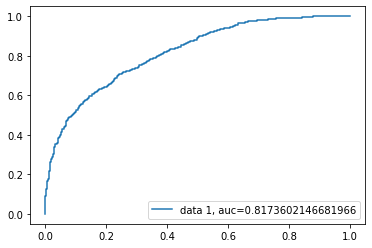

In [60]:
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(_ground_truth,  _predicted)
auc = roc_auc_score(_ground_truth, _predicted)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [63]:
check_accuracy(test_data_loader, torch.load('model.pth'))

Checking accuracy on test data


100%|██████████| 35/35 [00:00<00:00, 6301.81it/s]

Got 20 / 35 with accuracy 57.14
